# The reviews data

The data comes as a collection of json files. We can import these in an easy way with the following script (We only use the video games data)

In [1]:
import numpy as np
import pandas as pd
import gzip


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_reviews = getDF('./data/reviews_Video_Games_5.json.gz')
df_meta=getDF('./data/meta_Video_Games.json.gz')

#df_qa_toys_and_games = getDF('./data/qa_Toys_and_Games.json.gz')
#df_QA_toys_and_games = getDF('./data/QA_Toys_and_Games.json.gz')

We take a quick look at the data first. The reviews dataframe

In [2]:
df_reviews.head()

,asin,helpful,summary,reviewerName,reviewText,overall,unixReviewTime,reviewTime,reviewerID
0,0700099867,"[8, 12]",Pay to unlock content? I don't think so.,123,Installing the game was a struggle (because of...,1.0,1341792000,"07 9, 2012",A2HD75EMZR8QLN
1,0700099867,"[0, 0]",Good rally game,"Alejandro Henao ""Electronic Junky""",If you like rally cars get this game you will ...,4.0,1372550400,"06 30, 2013",A3UR8NLLY1ZHCX
2,0700099867,"[0, 0]",Wrong key,"Amazon Shopper ""Mr.Repsol""",1st shipment received a book instead of the ga...,1.0,1403913600,"06 28, 2014",A1INA0F5CWW3J4
3,0700099867,"[7, 10]","awesome game, if it did not crash frequently !!",ampgreen,"I got this version instead of the PS3 version,...",3.0,1315958400,"09 14, 2011",A1DLMTOTHQ4AST
4,0700099867,"[2, 2]",DIRT 3,"Angry Ryan ""Ryan A. Forrest""",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600,"06 14, 2011",A361M14PU2GUEG


and the meta data

In [3]:
df_meta.head()

,related,price,description,imUrl,salesRank,categories,asin,brand,title
0,"{'bought_together': ['B002I098JE'], 'also_boug...",37.98,Brand new sealed!,http://ecx.images-amazon.com/images/I/513h6dPb...,{'Video Games': 28655},"[[Video Games, Xbox 360, Games]]",0078764343,NaN,NaN
1,"{'buy_after_viewing': ['B000067NP1', '04395739...",23.50,In Stock NOW. Eligible for FREE Super Saving ...,http://ecx.images-amazon.com/images/I/61KKRndV...,{'Video Games': 44080},"[[Video Games, PC, Games]]",043933702X,NaN,NaN
2,"{'also_bought': ['B000314VVU', 'B000PXUOTE', '...",8.95,Grandma Groupers kelp seeds are missing and wi...,http://ecx.images-amazon.com/images/I/416QZg89...,{'Video Games': 49836},"[[Video Games, PC, Games]]",0439339987,NaN,NaN
3,{'also_viewed': ['043934302X']},NaN,This software is BRAND NEW. Packaging may diff...,http://ecx.images-amazon.com/images/I/61Wvu-Uj...,{'Video Games': 49156},"[[Video Games, PC, Games]]",0439342260,NaN,NaN
4,{'also_viewed': ['B00028D7TG']},NaN,a scholastic clubs fairs cd rom game,http://ecx.images-amazon.com/images/I/51k3oRCF...,{'Video Games': 52262},"[[Video Games, PC, Games]]",0439339960,NaN,NaN


For our purposes, it is important to see that the related feature has indeed more data, more precisely

In [4]:
df_meta.related.iloc[0]

{'also_bought': ['B000TI836G',
  'B003Q53VZC',
  'B00EFFW0HC',
  'B003VWGBC0',
  'B003O6G5TW',
  'B0037LTTRO',
  'B002I098JE',
  'B008OQTS0U',
  'B005EVEODY',
  'B008B3AVNE',
  'B000PE0HBS',
  'B00354NAYG',
  'B0050SYPV2',
  'B00503E8S2',
  'B0050SY77E',
  'B0022TNO7S',
  'B0056WJA30',
  'B0023CBY4E',
  'B002SRSQ72',
  'B005EZ5GQY',
  'B004XACA60',
  'B00273Z9WM',
  'B004HX1QFY',
  'B002I0K50U'],
 'bought_together': ['B002I098JE'],
 'buy_after_viewing': ['B0050SY5BM', 'B000TI836G', 'B0037LTTRO', 'B002I098JE']}

that is related is a dictionary with 3 keys 'also_bought', 'bought_together', and 'buy_after_viewing'

# Reviews in time

We want to understand when a product is released and try to figure what info we can get out of this, to do so we start by creating a collection of the reviews and the review time.

In [5]:
review_time=(df_reviews[['unixReviewTime','asin']].groupby('asin')
     .agg(lambda x:(list(x))))
review_time=review_time.applymap(lambda x: np.sort(np.array(x)));
review_time['initial']=review_time['unixReviewTime'].apply(lambda x:x[0])
review_time['review_days']=(review_time['unixReviewTime']-review_time['initial'])//(3600*24)
review_time=review_time.drop('unixReviewTime',axis=1)
review_time['day_last_review']=review_time['review_days'].apply(lambda x:x[-1])
review_time['nb_reviews']=review_time['review_days'].apply(lambda x:len(x))

We now graph the number of reviews against the days after the first review.

In [6]:
from collections import Counter
def create(days):
    X=[days[0]]
    Y=[0]
    current=0
    for day in days:
        if day==X[-1]:
            Y[current]+=1
        else:
            X.append(day)
            Y.append(Y[-1]+1)
            current+=1
    return X,Y

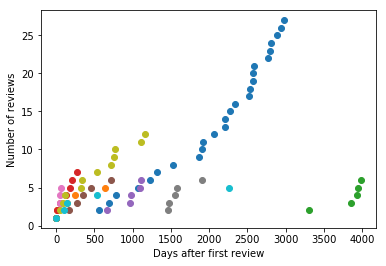

In [7]:
import matplotlib.pyplot as plt

sample=review_time.sample(10)
for days in sample.review_days:
    
    X,Y=create(days)
    #print(X,Y)
    plt.plot(X, Y,'o')
    
plt.xlabel("Days after first review")
plt.ylabel("Number of reviews")
plt.show()